# <center> Sending and receiving a pulse demonstration

### <center> In this demo you will send and receive a pulse in loopback to demonstrate control over the QICK. 

By modifying the <code> config </code> Python dictionary in the below notebook cell, you can change several variables:
* The pulse length <code> length </code> in FPGA clock ticks (1 clock tick = 2.6 ns).
* The readout buffer length <code> readout_length </code> in FPGA clock ticks.
* The pulse envelope shape <code> pulse_style </code> (either <code> const </code> or <code> flat_top </code> or <code> arb </code>)
* The pulse amplitude <code> pulse_gain </code> in DAC units.
* The pulse frequency <code> pulse_freq </code> in MHz.
* The readout "time of flight" <code> adc_trig_offset </code> in FPGA clock ticks.
* The number of times you average the read <code> soft_avgs </code>

In [1]:
# Import the QICK drivers and auxiliary libraries
from qick import *
from qick.helpers import gauss
import time
import numpy as np

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Load bitstream with custom overlay
soc = QickSoc()
# Set the loopback DAC channel to be in 1st Nyquist zone mode
soc.set_nyquist(ch=7,nqz=1); 

soc.set_nyquist(ch=6,nqz=1); 

'''Channel 1 : connected to Signal Generator V4, which drives DAC 228 CH0.
Channel 2 : connected to Signal Generator V4, which drives DAC 228 CH1. 
Channel 3 : connected to Signal Generator V4, which drives DAC 228 CH2. 
Channel 4 : connected to Signal Generator V4, which drives DAC 229 CH0. 
Channel 5 : connected to Signal Generator V4, which drives DAC 229 CH1. 
Channel 6 : connected to Signal Generator V4, which drives DAC 229 CH2. 
Channel 7 : connected to Signal Generator V4, which drives DAC 229 CH3. 
tiles: DAC 228: 0, DAC 229: 1 channels: CH0: 0, CH1: 1, CH2: 2, CH3: 3'''

resetting clocks: 204.8
Not all DAC and ADC PLLs are locked. You may want to repeat the initialization of the QickSoc.


'Channel 1 : connected to Signal Generator V4, which drives DAC 228 CH0.\nChannel 2 : connected to Signal Generator V4, which drives DAC 228 CH1. \nChannel 3 : connected to Signal Generator V4, which drives DAC 228 CH2. \nChannel 4 : connected to Signal Generator V4, which drives DAC 229 CH0. \nChannel 5 : connected to Signal Generator V4, which drives DAC 229 CH1. \nChannel 6 : connected to Signal Generator V4, which drives DAC 229 CH2. \nChannel 7 : connected to Signal Generator V4, which drives DAC 229 CH3. \ntiles: DAC 228: 0, DAC 229: 1 channels: CH0: 0, CH1: 1, CH2: 2, CH3: 3'

### Hardware Configuration

tProc channel 7   : DAC 229 CH3  <-> Readout channel 0 : ADC 224 CH0

In [6]:
class LoopbackProgram(AveragerProgram):
    def __init__(self,cfg):
        AveragerProgram.__init__(self,cfg)

    def initialize(self):
        cfg=self.cfg   
        r_freq=self.sreg(cfg["res_ch"], "freq")   #Get frequency register for res_ch
        self.cfg["adc_lengths"]=[self.cfg["readout_length"]]*2          #add length of adc acquisition to config
        self.cfg["adc_freqs"]=[self.cfg["pulse_freq"]]*2   #add frequency of adc ddc to config
        
        if self.cfg["pulse_style"] == "const":
            self.add_pulse(ch=self.cfg["res_ch"], name="measure",  style=self.cfg["pulse_style"], length=self.cfg["length"])  #add a constant pulse to the pulse library
            self.add_pulse(ch=self.cfg["res_ch_2"], name="measure",style=self.cfg["pulse_style"], length=self.cfg["length"])  #add a constant pulse to the pulse library
        if self.cfg["pulse_style"] == "flat_top":
            self.add_pulse(ch=self.cfg["res_ch"], name="measure", style=self.cfg["pulse_style"], length=self.cfg["length"], idata = self.cfg["idata"]) 
            self.add_pulse(ch=self.cfg["res_ch_2"], name="measure", style=self.cfg["pulse_style"], length=self.cfg["length"], idata = self.cfg["idata"]) 
        if self.cfg["pulse_style"] == "arb":
            self.add_pulse(ch=self.cfg["res_ch"], name="measure", style=self.cfg["pulse_style"], idata = self.cfg["idata"]) 
            self.add_pulse(ch=self.cfg["res_ch_2"], name="measure", style=self.cfg["pulse_style"], idata = self.cfg["idata"]) 
        
        freq=soc.freq2reg(cfg["pulse_freq"])  # convert frequency to dac frequency (ensuring it is an available adc frequency)
        
        
        self.pulse(ch=cfg["res_ch_2"], name="measure", freq=freq, phase=deg2reg(-90), outsel =2, gain=cfg["pulse_gain"], t= 0, play=False) # pre-configure readout pulse
        self.pulse(ch=cfg["res_ch"], name="measure", freq=freq, phase=deg2reg(-90), outsel = 2, gain=cfg["pulse_gain"], t= 0, play=False) # pre-configure readout pulse

        self.synci(200)  # give processor some time to configure pulses
    
    def body(self):
        self.synci(200) # give processor time to get ahead of the pulses
        self.trigger_adc(adc1=1, adc2=1,adc_trig_offset=self.cfg["adc_trig_offset"])  # trigger the adc acquisition
        if self.cfg["pulse_style"] == "const":
            self.pulse(ch=self.cfg["res_ch"], length=self.cfg["length"], outsel =2,  t=50, play=True) # play readout pulse
            self.pulse(ch=self.cfg["res_ch"], length=self.cfg["length"], outsel =2, t=250, play=True) # play readout pulse

            self.pulse(ch=self.cfg["res_ch_2"],length=self.cfg["length"], t=0, play=True) # play readout pulse
            #self.pulse(ch=self.cfg["res_ch_2"], length=self.cfg["length"], t=100, play=True) # play readout pulse
            #self.pulse(ch=self.cfg["res_ch_2"], length=self.cfg["length"], t=200, play=True) # play readout pulse
            #self.pulse(ch=self.cfg["res_ch_2"], length=self.cfg["length"], t=500, play=True) # play readout pulse

        if self.cfg["pulse_style"] == "flat_top":
            self.pulse(ch=self.cfg["res_ch"], name="measure", play=True) # play readout pulse
            self.pulse(ch=self.cfg["res_ch_2"], name="measure", play=True) # play readout pulse
            #self.pulse(ch=self.cfg["res_ch_2"], length=self.cfg["length"], t=100, play=True) # play readout pulse
            #self.pulse(ch=self.cfg["res_ch_2"], length=self.cfg["length"], t=200, play=True) # play readout pulse
            #self.pulse(ch=self.cfg["res_ch_2"], length=self.cfg["length"], t=500, play=True) # play readout pulse

        if self.cfg["pulse_style"] == "arb":
            self.pulse(ch=self.cfg["res_ch"], play=True) # play readout pulse
        # control should wait until the readout is over
        self.waiti(0, self.cfg["adc_trig_offset"]+self.cfg["readout_length"]) 
        self.sync_all(soc.us2cycles(self.cfg["relax_delay"]))  # sync all channels


### Send/receive a pulse with <code> pulse_style </code> = <code> const </code>

In [11]:
config={"res_ch":7, # --Fixed
        "res_ch_2":6, 
        "reps":1, # --Fixed
        "relax_delay":1, # --Fixed
        "res_phase":0, # --Fixed
        "pulse_style": "const", # --Fixed
        
        "length":100, # [Clock ticks]
        # Try varying length from 10-100 clock ticks
        
        "readout_length":200, # [Clock ticks]
        # Try varying readout_length from 50-1000 clock ticks

        "pulse_gain":30000, # [DAC units]
        # Try varying pulse_gain from 500 to 30000 DAC units

        "pulse_freq":100, # [MHz]
        # In this program the signal is up and downconverted digitally so you won't see any frequency
        # components in the I/Q traces below. But since the signal gain depends on frequency, 
        # if you lower pulse_freq you will see an increased gain.

        "adc_trig_offset": 150, # [Clock ticks]
        # Try varying adc_trig_offset from 100 to 220 clock ticks

        "soft_avgs":100
        # Try varying soft_avgs from 1 to 200 averages

       }

###################
# Try it yourself !
###################

prog =LoopbackProgram(config)

iq0, iq1= prog.acquire_decimated(soc, load_pulses=True, progress=True, debug=False)


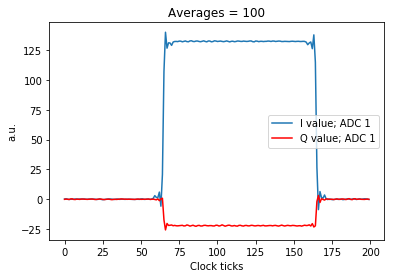

In [5]:
# Plot results.
plt.figure(1)
#plt.plot(iq0[0], label="I value; ADC 0")
#plt.plot(iq0[1], label="Q value; ADC 0")
plt.plot(iq1[0], label="I value; ADC 1")
plt.plot(iq1[1],'r-', label="Q value; ADC 1")
plt.ylabel("a.u.")
plt.xlabel("Clock ticks")
plt.title("Averages = " + str(config["soft_avgs"]))
plt.legend()
plt.savefig("images/Send_recieve_pulse_const.pdf", dpi=350)

In [79]:
sample_iq1 = iq1

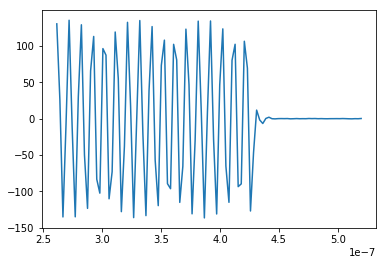

In [71]:
readout_length = config["readout_length"]
time_list = np.linspace(0, readout_length*2.6*(10**(-9)), len(iq0[0]))
voltage_list = []
voltage_list_ch_6 = []
voltage_list_ch_6_1 = []
voltage_list_ch_6_2 = []
voltage_list_ch_6_3 = []
voltage_list_ch_6_4 = []

start = 0
for i in range(start, len(iq0[0])):
    voltage_list.append(iq0[0][i]*np.cos(2*np.pi*(10**6)*time_list[i]) +iq0[1][i]*np.sin(2*np.pi*(10**6)*time_list[i]))  
    voltage_list_ch_6.append(iq1[0][i]*np.cos(2*np.pi*(10**7)*time_list[i]) +iq1[1][i]*np.sin(2*np.pi*(10**7)*time_list[i]))  
    voltage_list_ch_6_1.append(iq1[0][i]*np.cos(2*np.pi*(10**6)*time_list[i]) +iq1[1][i]*np.sin(2*np.pi*(10**6)*time_list[i]))  
    voltage_list_ch_6_2.append(iq1[0][i]*np.cos(2*np.pi*(10**5)*time_list[i]) +iq1[1][i]*np.sin(2*np.pi*(10**5)*time_list[i]))  
    voltage_list_ch_6_3.append(iq1[0][i]*np.cos(2*np.pi*(10**4)*time_list[i]) +iq1[1][i]*np.sin(2*np.pi*(10**4)*time_list[i]))  

    voltage_list_ch_6_4.append(iq1[0][i]*np.cos(2*np.pi*(10**8)*time_list[i]) +iq1[1][i]*np.sin(2*np.pi*(10**8)*time_list[i]))  


#plt.plot(time_list[start:], voltage_list, 'r.')
#plt.plot(time_list[start:], voltage_list)
#plt.plot(time_list[start:], voltage_list_ch_6)
#plt.plot(time_list[start:], voltage_list_ch_6_1)
#plt.plot(time_list[start:], voltage_list_ch_6_2)
#plt.plot(time_list[start:], voltage_list_ch_6_3)
plt.plot(time_list[start+100:], voltage_list_ch_6_4[start+100:])

plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))

In [58]:
class LoopbackProgram_2(AveragerProgram):
    def __init__(self,cfg):
        AveragerProgram.__init__(self,cfg)

    def initialize(self):
        cfg=self.cfg   
        r_freq=self.sreg(cfg["res_ch"], "freq")   #Get frequency register for res_ch
        self.cfg["adc_lengths"]=[self.cfg["readout_length"]]*2          #add length of adc acquisition to config
        self.cfg["adc_freqs"]=[self.cfg["pulse_freq"]]*2   #add frequency of adc ddc to config
        
        if self.cfg["pulse_style"] == "const":
            self.add_pulse(ch=self.cfg["res_ch"], name="measure", style=self.cfg["pulse_style"], length=self.cfg["length"])  #add a constant pulse to the pulse library
        if self.cfg["pulse_style"] == "flat_top":
            self.add_pulse(ch=self.cfg["res_ch"], name="measure", style=self.cfg["pulse_style"], length=self.cfg["length"], idata = self.cfg["idata"]) 
        if self.cfg["pulse_style"] == "arb":
            self.add_pulse(ch=self.cfg["res_ch"], name="measure", style=self.cfg["pulse_style"], idata = self.cfg["idata"]) 
        
        freq=soc.freq2reg(cfg["pulse_freq"])  # convert frequency to dac frequency (ensuring it is an available adc frequency)
        self.pulse(ch=cfg["res_ch"], name="measure", freq=freq, phase=deg2reg(0), gain=cfg["pulse_gain"], t= 0, play=False) # pre-configure readout pulse

        self.synci(200)  # give processor some time to configure pulses
    
    def body(self):
        self.synci(200) # give processor time to get ahead of the pulses
        self.trigger_adc(adc1=1, adc2=1,adc_trig_offset=self.cfg["adc_trig_offset"])  # trigger the adc acquisition
        if self.cfg["pulse_style"] == "const":
            self.pulse(ch=self.cfg["res_ch"], length=self.cfg["length"], play=True) # play readout pulse
            
        if self.cfg["pulse_style"] == "flat_top":
            self.pulse(ch=self.cfg["res_ch"], name="measure", play=True) # play readout pulse
        if self.cfg["pulse_style"] == "arb":
            self.pulse(ch=self.cfg["res_ch"], play=True) # play readout pulse
        # control should wait until the readout is over
        self.waiti(0, self.cfg["adc_trig_offset"]+self.cfg["readout_length"]) 
        self.sync_all(soc.us2cycles(self.cfg["relax_delay"]))  # sync all channels


In [16]:
config_1 = {"res_ch":7, # --Fixed
        "reps":1, # --Fixed
        "relax_delay":1, # --Fixed
        "res_phase":0, # --Fixed
        "pulse_style": "const", # --Fixed
        
        "length":10, # [Clock ticks]
        # Try varying length from 10-100 clock ticks
        
        "readout_length":50, # [Clock ticks]
        # Try varying readout_length from 50-1000 clock ticks

        "pulse_gain":3000, # [DAC units]
        # Try varying pulse_gain from 500 to 30000 DAC units

        "pulse_freq": 100, # [MHz]
        # In this program the signal is up and downconverted digitally so you won't see any frequency
        # components in the I/Q traces below. But since the signal gain depends on frequency, 
        # if you lower pulse_freq you will see an increased gain.

        "adc_trig_offset": 200, # [Clock ticks]
        # Try varying adc_trig_offset from 100 to 220 clock ticks

        "soft_avgs":100
        # Try varying soft_avgs from 1 to 200 averages

       }


config_2 = {"res_ch":6, # --Fixed
        "reps":1, # --Fixed
        "relax_delay":1, # --Fixed
        "res_phase":0, # --Fixed
        "pulse_style": "const", # --Fixed
        
        "length":100, # [Clock ticks]
        # Try varying length from 10-100 clock ticks
        
        "readout_length":200, # [Clock ticks]
        # Try varying readout_length from 50-1000 clock ticks

        "pulse_gain":3000, # [DAC units]
        # Try varying pulse_gain from 500 to 30000 DAC units

        "pulse_freq": 100, # [MHz]
        # In this program the signal is up and downconverted digitally so you won't see any frequency
        # components in the I/Q traces below. But since the signal gain depends on frequency, 
        # if you lower pulse_freq you will see an increased gain.

        "adc_trig_offset": 200, # [Clock ticks]
        # Try varying adc_trig_offset from 100 to 220 clock ticks

        "soft_avgs":100
        # Try varying soft_avgs from 1 to 200 averages

       }


prog_1 =LoopbackProgram_2(config_1)
prog_2 =LoopbackProgram_2(config_2)


start_time = time.time()

iq01, iq11= prog_1.acquire_decimated(soc, load_pulses=True, progress=True, debug=False)

curr_time = time.time() - start_time

print('Time to generate pulse 1 and read it is', curr_time)


iq02, iq12 = prog_2.acquire_decimated(soc, load_pulses=True, progress=True, debug=False)

print('Time to generate pulse 1 and 2 and read them is',time.time() - start_time)

time1 = np.linspace(0, 1, len(iq01[0]))
time2 = np.linspace(curr_time, curr_time + 1, len(iq12[0]))



Time to generate pulse 1 and read it is 0.3910839557647705



Time to generate pulse 1 and 2 and read them is 0.7950396537780762


In [6]:

plt.figure(1)
plt.plot(time1, iq01[0], label="I value; ADC 0")
plt.plot(time1, iq01[1], label="Q value; ADC 0")
plt.plot(time2, iq12[0], label="I value; ADC 1")
plt.plot(time2, iq12[1], label="Q value; ADC 1")
plt.ylabel("a.u.")
plt.xlabel("seconds")
plt.title("Averages = " + str(config["soft_avgs"]))
plt.legend()
plt.savefig("images/Send_recieve_pulse_const.pdf", dpi=350)

NameError: name 'time1' is not defined

### Send/receive a pulse with <code> pulse_style </code> = <code> flat_top </code>

In [104]:
class LoopbackProgram(AveragerProgram):
    def __init__(self,cfg):
        AveragerProgram.__init__(self,cfg)

    def initialize(self):
        cfg=self.cfg   
        r_freq=self.sreg(cfg["res_ch"], "freq")   #Get frequency register for res_ch
        self.cfg["adc_lengths"]=[self.cfg["readout_length"]]*2          #add length of adc acquisition to config
        self.cfg["adc_freqs"]=[self.cfg["pulse_freq"]]*2   #add frequency of adc ddc to config
        
        if self.cfg["pulse_style"] == "const":
            self.add_pulse(ch=self.cfg["res_ch"], name="measure", style=self.cfg["pulse_style"], length=self.cfg["length"])  #add a constant pulse to the pulse library
        if self.cfg["pulse_style"] == "flat_top":
            self.add_pulse(ch=self.cfg["res_ch"], name="measure", style=self.cfg["pulse_style"], length=self.cfg["length"], idata = self.cfg["idata"]) 
            self.add_pulse(ch=self.cfg["res_ch_2"], name="measure", style=self.cfg["pulse_style"], length=self.cfg["length"], idata = self.cfg["idata"]) 

        if self.cfg["pulse_style"] == "arb":
            self.add_pulse(ch=self.cfg["res_ch"], name="measure", style=self.cfg["pulse_style"], idata = self.cfg["idata"]) 
            self.add_pulse(ch=self.cfg["res_ch_2"], name="measure", style=self.cfg["pulse_style"], idata = self.cfg["idata"]) 

        freq=soc.freq2reg(cfg["pulse_freq"])  # convert frequency to dac frequency (ensuring it is an available adc frequency)
        self.pulse(ch=cfg["res_ch"], name="measure", freq=freq, phase=0, gain=cfg["pulse_gain"],  t=10, play=False) # pre-configure readout pulse

        self.pulse(ch=cfg["res_ch_2"], name="measure", freq=freq, phase=0, gain=cfg["pulse_gain"],  t= 0, play=False) # pre-configure readout pulse
 
        self.synci(200)  # give processor some time to configure pulses
    
    def body(self):
        self.synci(200) # give processor time to get ahead of the pulses
        self.trigger_adc(adc1=1, adc2=1,adc_trig_offset=self.cfg["adc_trig_offset"])  # trigger the adc acquisition
        if self.cfg["pulse_style"] == "const":
            self.pulse(ch=self.cfg["res_ch"], length=self.cfg["length"], play=True) # play readout pulse
        if self.cfg["pulse_style"] == "flat_top":
            self.pulse(ch=self.cfg["res_ch"], name="measure", play=True) # play readout pulse
            self.pulse(ch=self.cfg["res_ch_2"], name="measure", play=True) # play readout pulse

        if self.cfg["pulse_style"] == "arb":
            self.pulse(ch=self.cfg["res_ch"], outsel = 2, t = 10, play=True) # play readout pulse
            self.pulse(ch=self.cfg["res_ch"], gain = 1000, outsel = 1, t = 210, play=True) # play readout pulse
            
            self.pulse(ch=self.cfg["res_ch_2"], play =True) # play readout pulse
        # control should wait until the readout is over
        self.waiti(0, self.cfg["adc_trig_offset"]+self.cfg["readout_length"]) 
        self.sync_all(soc.us2cycles(self.cfg["relax_delay"]))  # sync all channels


In [124]:
idata = []
qdata = []

'''
for i in range(3200):
    idata.append(-20000-4*i) #optimal square wave
    qdata.append(0)
'''    
for i in range(320):
    idata.append(-60000-100*i) #optimal square wave
    qdata.append(0)
    
for i in range(320, 2900):
    idata.append(-20000-4*i) #optimal square wave
    qdata.append(0)
    
for i in range(2900, 3200):
    idata.append(-60000+100*i) #optimal square wave
    qdata.append(0)
    
idata = np.array(idata)
qdata = np.array(qdata)    
    
    
config={"res_ch":7, # --Fixed
        "res_ch_2":6,
        "reps":1, # --Fixed
        "relax_delay":1, # --Fixed
        "res_phase":0, # --Fixed
        "pulse_style": "arb", # --Fixed
        "readout_length":400, # [Clock ticks]
        # Try varying readout_length from 50-1000 clock ticks

        "pulse_gain":20000, # [DAC units]
        # Try varying pulse_gain from 500 to 30000 DAC units
        "zero_pulse_gain":0,

        "pulse_freq": 100, # [MHz]
        # In this program the signal is up and downconverted digitally so you won't see any frequency
        # components in the I/Q traces below. But since the signal gain depends on frequency, 
        # if you lower pulse_freq you will see an increased gain.

        "adc_trig_offset": 200, # [Clock ticks]
        # Try varying adc_trig_offset from 100 to 220 clock ticks

        "soft_avgs":100
        # Try varying soft_avgs from 1 to 200 averages

       }


config["idata"] = idata
config["qdata"] = qdata
# Try varying idata to be an arbitrary numpy array of your choosing!

###################
# Try it yourself !
###################

prog =LoopbackProgram(config)
iq0, iq1 = prog.acquire_decimated(soc, load_pulses=True, progress=True, debug=False)


In [76]:
config={"res_ch":7, # --Fixed
        "res_ch_2":6,
        "reps":1, # --Fixed
        "relax_delay":1, # --Fixed
        "res_phase":0, # --Fixed
        "pulse_style": "flat_top", # --Fixed
        "length": 100, # [Clock ticks]
        # Try varying  length from 10-100 clock ticks
        "sigma": 10, # [Clock ticks]
        # Try varying sigma from 10-50 clock ticks
        
        "readout_length":200, # [Clock ticks]
        # Try varying readout_length from 50-1000 clock ticks

        "pulse_gain":30000, # [DAC units]
        # Try varying pulse_gain from 500 to 30000 DAC units

        "pulse_freq": 10, # [MHz]
        # In this program the signal is up and downconverted digitally so you won't see any frequency
        # components in the I/Q traces below. But since the signal gain depends on frequency, 
        # if you lower pulse_freq you will see an increased gain.

        "adc_trig_offset": 200, # [Clock ticks]
        # Try varying adc_trig_offset from 100 to 220 clock ticks

        "soft_avgs":150
        # Try varying soft_avgs from 1 to 200 averages

       }
config["idata"] = gauss(mu=config["sigma"]*16*5/2,si=config["sigma"]*16,length=5*config["sigma"]*16,maxv=32000)
# Try varying idata to be an arbitrary numpy array of your choosing!
# The first half of idata ramps up the flat_top pulse, the second half ramps down the flat_top pulse

###################
# Try it yourself !
###################

prog =LoopbackProgram(config)
iq0, iq1 = prog.acquire_decimated(soc, load_pulses=True, progress=True, debug=False)


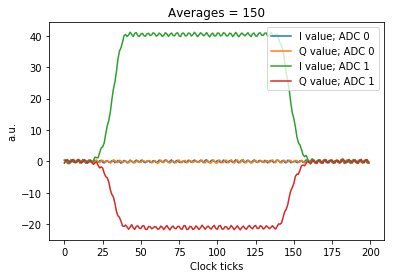

In [85]:
# Plot results.
plt.figure(1)
plt.plot(iq0[0], label="I value; ADC 0")
plt.plot(iq0[1], label="Q value; ADC 0")
plt.plot(iq1[0], label="I value; ADC 1")
plt.plot(iq1[1], label="Q value; ADC 1")
plt.ylabel("a.u.")
plt.xlabel("Clock ticks")
plt.title("Averages = " + str(config["soft_avgs"]))
plt.legend()
plt.savefig("images/Send_recieve_pulse_flattop.pdf", dpi=350)

### Send/receive a pulse with <code> pulse_style </code> = <code> arb </code>

In [31]:
config={"res_ch":7, # --Fixed
        "res_ch_2":6,
        "reps":1, # --Fixed
        "relax_delay":1, # --Fixed
        "res_phase":0, # --Fixed
        "pulse_style": "arb", # --Fixed
        
        "sigma": 30, # [Clock ticks]
        # Try varying sigma from 10-50 clock ticks
        
        "readout_length":200, # [Clock ticks]
        # Try varying readout_length from 50-1000 clock ticks

        "pulse_gain":20000, # [DAC units]
        # Try varying pulse_gain from 500 to 30000 DAC units

        "pulse_freq": 100, # [MHz]
        # In this program the signal is up and downconverted digitally so you won't see any frequency
        # components in the I/Q traces below. But since the signal gain depends on frequency, 
        # if you lower pulse_freq you will see an increased gain.

        "adc_trig_offset": 200, # [Clock ticks]
        # Try varying adc_trig_offset from 100 to 220 clock ticks

        "soft_avgs":100
        # Try varying soft_avgs from 1 to 200 averages

       }
config["idata"] = gauss(mu=config["sigma"]*16*5/2,si=config["sigma"]*16,length=5*config["sigma"]*16,maxv=32000)
# Try varying idata to be an arbitrary numpy array of your choosing!


###################
# Try it yourself !
###################

prog =LoopbackProgram(config)
iq0, iq1 = prog.acquire_decimated(soc, load_pulses=True, progress=True, debug=False)


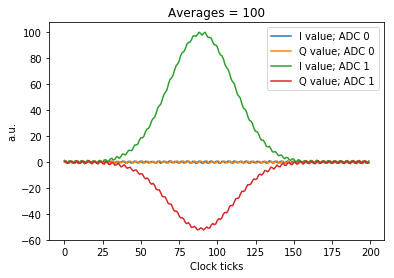

In [199]:
# Plot results.
plt.figure(1)
plt.plot(iq0[0], label="I value; ADC 0")
plt.plot(iq0[1], label="Q value; ADC 0")
plt.plot(iq1[0], label="I value; ADC 1")
plt.plot(iq1[1], label="Q value; ADC 1")
plt.ylabel("a.u.")
plt.xlabel("Clock ticks")
plt.title("Averages = " + str(config["soft_avgs"]))
plt.legend()
plt.savefig("images/Send_recieve_pulse_arb.pdf", dpi=350)

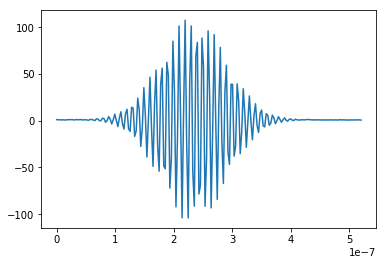

In [215]:
readout_length = config["readout_length"]
time_list = np.linspace(0, readout_length*2.6*(10**(-9)), len(iq0[0]))
voltage_list = []
voltage_list_ch_6 = []
voltage_list_ch_6_1 = []
voltage_list_ch_6_2 = []
voltage_list_ch_6_3 = []
voltage_list_ch_6_4 = []

start = 0
for i in range(start, len(iq0[0])):
    voltage_list.append(iq0[0][i]*np.cos(2*np.pi*(10**6)*time_list[i]) +iq0[1][i]*np.sin(2*np.pi*(10**6)*time_list[i]))  
    voltage_list_ch_6.append(iq1[0][i]*np.cos(4*np.pi*(10**10)*time_list[i]) +iq1[1][i]*np.sin(4*np.pi*(10**10)*time_list[i]))  
    voltage_list_ch_6_1.append(iq1[0][i]*np.cos(2*np.pi*(10**6)*time_list[i]) +iq1[1][i]*np.sin(2*np.pi*(10**6)*time_list[i]))  
    voltage_list_ch_6_2.append(iq1[0][i]*np.cos(2*np.pi*(10**5)*time_list[i]) +iq1[1][i]*np.sin(2*np.pi*(10**5)*time_list[i]))  
    voltage_list_ch_6_3.append(iq1[0][i]*np.cos(2*np.pi*(10**4)*time_list[i]) +iq1[1][i]*np.sin(2*np.pi*(10**4)*time_list[i]))  

    voltage_list_ch_6_4.append(iq1[0][i]*np.cos(2*np.pi*(10**3)*time_list[i]) +iq1[1][i]*np.sin(2*np.pi*(10**3)*time_list[i]))  


#plt.plot(time_list[start:], voltage_list, 'r.')
#plt.plot(time_list[start:], voltage_list)
plt.plot(time_list[start:], voltage_list_ch_6)
#plt.plot(time_list[start:], voltage_list_ch_6_1)
#plt.plot(time_list[start:], voltage_list_ch_6_2)
#plt.plot(time_list[start:], voltage_list_ch_6_3)
#plt.plot(time_list[start:], voltage_list_ch_6_4)

plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))


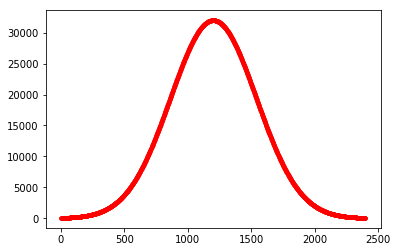

In [36]:
plt.plot(gauss(mu=config["sigma"]*16*5/2,si=config["sigma"]*16,length=5*config["sigma"]*16,maxv=32000), 'r.')

In [230]:

#one clock tick = 2.6 ns

#1600 iq datapoint = 100 clockticks

    
config={"res_ch":7, # --Fixed
        "res_ch_2":6,
        "reps":1, # --Fixed
        "relax_delay":1, # --Fixed
        "res_phase":0, # --Fixed
        "pulse_style": "arb", # --Fixed
        "readout_length":400, # [Clock ticks]
        # Try varying readout_length from 50-1000 clock ticks

        "pulse_gain":5000, # [DAC units]
        # Try varying pulse_gain from 500 to 30000 DAC units

        "pulse_freq": 100, # [MHz]
        # In this program the signal is up and downconverted digitally so you won't see any frequency
        # components in the I/Q traces below. But since the signal gain depends on frequency, 
        # if you lower pulse_freq you will see an increased gain.

        "adc_trig_offset": 200, # [Clock ticks]
        # Try varying adc_trig_offset from 100 to 220 clock ticks

        "soft_avgs":100
        # Try varying soft_avgs from 1 to 200 averages

       }

idata = []
qdata = []
trig_factor = 4*np.pi*10**(10)
time_constant = 2.6*(10**(-9))

for i in range(200):
    for j in range(16):
        idata.append(np.cos(trig_factor*time_constant*i) )
        qdata.append(np.sin(trig_factor*time_constant*i))
        #idata.append(1)
        #qdata.append(1)
    #qdata.append(0)
    

    
idata = 32000*np.array(idata)
qdata = 32000*np.array(qdata)    
    
config["idata"] = idata
config["qdata"] = qdata
# Try varying idata to be an arbitrary numpy array of your choosing!

###################
# Try it yourself !
###################

prog =LoopbackProgram(config)
iq0, iq1 = prog.acquire_decimated(soc, load_pulses=True, progress=True, debug=False)


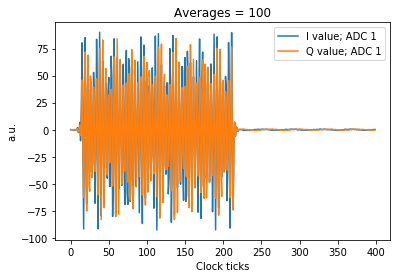

In [101]:
# Plot results.
plt.figure(1)
#plt.plot(iq0[0], label="I value; ADC 0")
#plt.plot(iq0[1], label="Q value; ADC 0")
plt.plot(iq1[0], label="I value; ADC 1")
plt.plot(iq1[1], label="Q value; ADC 1")
plt.ylabel("a.u.")
plt.xlabel("Clock ticks")
plt.title("Averages = " + str(config["soft_avgs"]))
plt.legend()
plt.savefig("images/Send_recieve_pulse_arb.pdf", dpi=350)

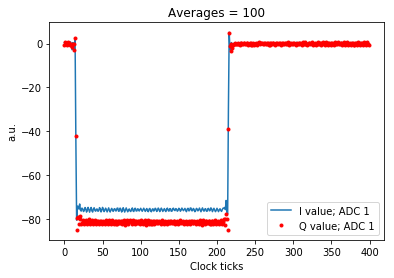

In [101]:
# Plot results.
plt.figure(1)
#plt.plot(iq0[0], label="I value; ADC 0")
#plt.plot(iq0[1], label="Q value; ADC 0")
plt.plot(iq1[0], label="I value; ADC 1")
plt.plot(iq1[1], 'r.', label="Q value; ADC 1")
plt.ylabel("a.u.")
plt.xlabel("Clock ticks")
plt.title("Averages = " + str(config["soft_avgs"]))
plt.legend()
plt.savefig("images/Send_recieve_pulse_arb.pdf", dpi=350)

### Compare the two main ways of acquiring data: <code> prog.acquire_decimated </code> and <code> prog.acquire </code>

In the previous two demonstrations we used <code> prog.acquire_decimated </code> which uses the QICK decimated buffer (acquiring a whole time trace of data for every measurement shot. The QICK accumulated buffer is used in <code> prog.acquire </code>, which acquires a single I/Q data point per measurement shot- the average of the I/Q values in the decimated buffer. In qubit experiments we will be mainly using <code> prog.acquire </code> since for every shot we only need one I/Q value to assess the state of the qubit. So let's verify that <code> prog.acquire_decimated </code> and <code> prog.acquire </code> produce similar results (to within +/- 5 DAC units).

In [24]:
# First, lets collect the results with the decimated buffer as we did before.
config={"res_ch":7, # --Fixed
        "reps":1, # --Fixed
        "relax_delay":1, # --Fixed
        "res_phase":0, # --Fixed
        "pulse_style": "const", # --Fixed
        "length":20, # [Clock ticks]        
        "readout_length":200, # [Clock ticks]
        "pulse_gain":10000, # [DAC units]
        "pulse_freq": 100, # [MHz]
        "adc_trig_offset": 100, # [Clock ticks]
        "soft_avgs":100
       }

prog =LoopbackProgram(config)
iq0, iq1 = prog.acquire_decimated(soc, load_pulses=True, progress=True, debug=False)


In [25]:
print("I value; ADC 0; Decimated buffer: ",  np.mean(iq0[0]))
print("Q value; ADC 0; Decimated buffer: ", np.mean(iq0[1]))


I value; ADC 0; Decimated buffer:  5.567150000000001
Q value; ADC 0; Decimated buffer:  44.569700000000005


In [26]:
# Now, lets collect the results with the accumulated buffer. 
config["reps"] = 100; # Set reps equal to soft_avgs in the prior acquisition method

prog =LoopbackProgram(config)
avgi, avgq = prog.acquire(soc, load_pulses=True)

In [27]:
print("I value; ADC 0; Accumulated buffer: ", avgi[0])
print("Q value; ADC 0; Accumulated buffer: ", avgq[0])


I value; ADC 0; Accumulated buffer:  [5.59815]
Q value; ADC 0; Accumulated buffer:  [44.5658]


In [28]:
print(prog)


// Program

        regwi 3, $16, 69905066;                 //freq = 69905066
        regwi 3, $17, 0;                        //phase = 0
        regwi 3, $19, 10000;                    //gain = 10000
        regwi 3, $21, 0;                        //t = 0
        regwi 3, $20, 589844;                   //stdysel | mode | outsel = 0b01001 | length = 20 
        synci 200;
        regwi 0, $15, 0;
        regwi 0, $14, 99;
LOOP_J: synci 200;
        regwi 0, $31, 49152;                    //out = 0b1100000000000000
        seti 0, 0, $31, 100;                    //ch =0 out = $31 @t = 0
        regwi 0, $31, 0;                        //out = 0b0000000000000000
        seti 0, 0, $31, 110;                    //ch =0 out = $31 @t = 0
        regwi 3, $20, 589844;                   //stdysel | mode | outsel = 0b01001 | length = 20 
        regwi 3, $21, 0;                        //t = 0
        set 7, 3, $16, $17, $18, $19, $20, $21; //ch = 7, out = $16,$17,$18,$19,$20 @t = $21
        wa